This notebook shows how BigBang can be used to display a graph of interactions in the mailing list over some period of time.

First we'll make the I Python notebook display computed visualizations inline.

In [1]:
%matplotlib inline

Next we'll import dependencies.

In [2]:
from bigbang.archive import Archive
import bigbang.parse as parse
import bigbang.graph as graph
import bigbang.mailman as mailman
import bigbang.process as process
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint as pp
import pytz

Now we will use BigBang to process mailing list archives we've already downloaded.

Note that you can load an Archive that you have stored locally in a .csv file just by using its shortened *name*. You can also still include full URL's if you haven't downloaded the data yet, or you aren't sure.

In [3]:
urls = ["ipython-dev",
        "hot",
        "scipy-user",
        "https://lists.wikimedia.org/pipermail/gendergap/",
        "ipython-user"]

archives= [Archive(url,archive_dir="../../archives") for url in urls]

Here we will set the window for analysis. By default, November 2011.

In [4]:
date_from = pd.datetime(2011,11,1,tzinfo=pytz.utc)
date_to = pd.datetime(2011,12,1,tzinfo=pytz.utc)

This is a helper function to select messages from a dataframe that fall within a certain range of dates.

In [5]:
def filter_by_date(df,d_from,d_to):
    return df[(df['Date'] > d_from) & (df['Date'] < d_to)]

A function for drawing interaction graphs.

*TODO: Move this into the library code*

Note that this method requires that you have `pydot` installed.

In [6]:
def draw_interaction_graph(ig):
    #pdig = nx.to_pydot(ig)
    #pdig.set_overlap('False')
    
    pos = nx.drawing.nx_pydot.graphviz_layout(ig,prog='neato')
    node_size = [data['sent'] * 40 for name,data in ig.nodes(data=True)]

    nx.draw(ig,
        pos,
        node_size = node_size,
        node_color = 'w',
        alpha = 0.4,
        font_size=18,
        font_weight='bold'
    )


    # edge width is proportional to replies sent
    edgewidth=[d['weight'] for (u,v,d) in ig.edges(data=True)]

    #overlay edges with width based on weight
    nx.draw_networkx_edges(ig,pos,alpha=0.5,width=edgewidth,edge_color='r')

Now we'll use BigBang's graph processing methods to turn the processed messages into a graph of interactions.

ipython-dev
-0.442541410433
hot
-0.204913127515
scipy-user
-0.131527105478
https://lists.wikimedia.org/pipermail/gendergap/
-0.292926048744
ipython-user
-0.6545197369


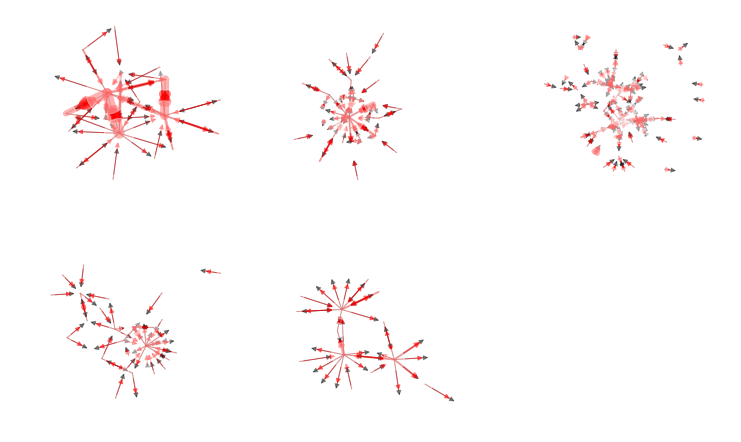

In [7]:
plt.figure(230,figsize=(12.5, 7.5))
for i,arx in enumerate(archives):
    plt.subplot(231 + i) # create a subplot keyed to the index of this ml
    df = arx.data
    dff = filter_by_date(df,date_from,date_to)
    ig = graph.messages_to_interaction_graph(dff)
    print urls[i]
    print nx.degree_assortativity_coefficient(ig)
    draw_interaction_graph(ig)

plt.show()

In [8]:
dfs = [filter_by_date(arx.data,
                      date_from,
                      date_to) for arx in archives]

bdf = pd.concat(dfs)

#RG = graph.messages_to_reply_graph(messages)

IG = graph.messages_to_interaction_graph(bdf)

pdig = nx.drawing.nx_pydot.to_pydot(IG)

pdig.set_overlap('False')


Lastly, we use NetworkX's built in compatibility with Matplotlib to visualize the graph.

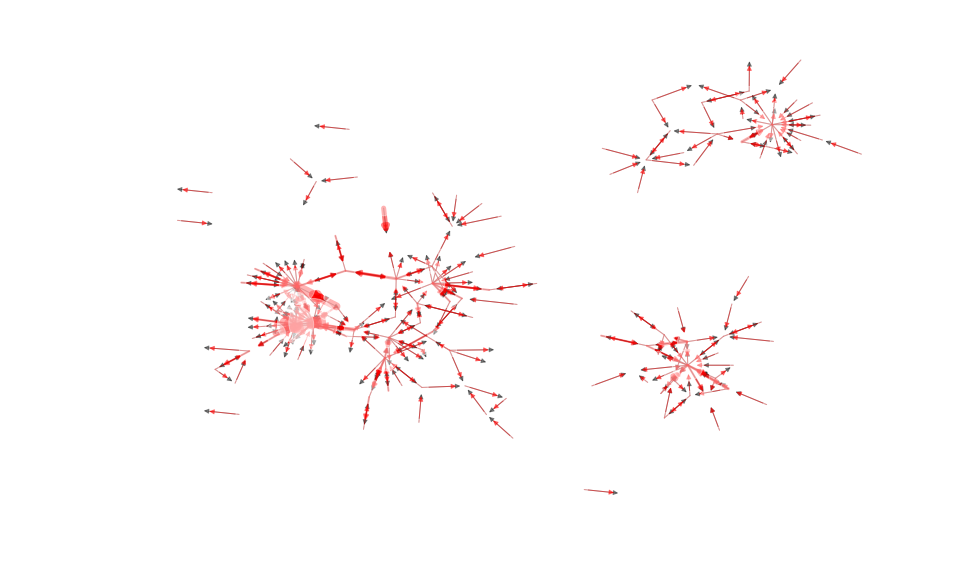

In [9]:
plt.figure(figsize=(12.5,7.5))

draw_interaction_graph(IG)

plt.show()

In [10]:
nx.write_edgelist(IG, "ig-edges.txt",delimiter="\t")

In [11]:
nx.write_gexf(IG,"all.gexf")